In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pynq import allocate, Overlay,GPIO
from pynq import lib
from pynq.lib.video import *

import cv2 as cv


In [2]:
design = Overlay("HLSImageProcessor.bit")
design?

image_process_ip = design.ImageProcessor_0
image_process_vdma = design.axi_vdma_0
canny_vdma = design.axi_vdma_1
canny_ip = design.canny_edge_detection_0

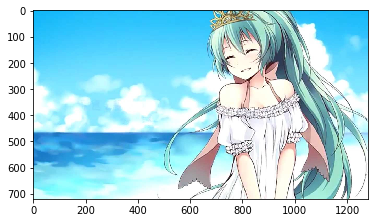

In [4]:
# enum ProcessTypes {
#     PROCESS_ORIGIN	= 0, //
# 	PROCESS_GRAY	= 1, //
# 	PROCESS_SOBEL	= 2, //
# 	PROCESS_GAUSSIAN	= 3, //
# 	PROCESS_CANNY	= 4
# };
pl_methods ={'Gray':0,
            'Original':0,
            'Sobel':2,
             'Gaussian':3,
             'Canny':4,
            }

image_path = "../pictures/4.jpg"
mat_image = cv.imread(image_path,cv.IMREAD_UNCHANGED)
#测试用Ipl格式原图
original_plt_image = Image.open(image_path)
#Mat转PLT
plt_image = Image.fromarray(cv.cvtColor(mat_image,cv.COLOR_BGR2RGB))
#通道变化
rgba_plt_image=plt_image.convert('RGBA')
plt.imshow(rgba_plt_image)
#获取高度宽度
width, height = plt_image.size

In [36]:
#写入内存映射宽高
mode = 2#0,1 gray 2sobel 3 gaussian 
arg1=0
arg2=0
image_process_ip.write(0x10,mode)
image_process_ip.write(0x18, height)
image_process_ip.write(0x20, width)
image_process_ip.write(0x28, arg1)
image_process_ip.write(0x30, arg2)
image_process_ip.write(0x00,0x81) # start 必须加不然卡死

image_process_vdma.readchannel.mode=VideoMode(width,height,32)
image_process_vdma.readchannel.start()

image_process_vdma.writechannel.mode=VideoMode(width,height,32)
image_process_vdma.writechannel.start()

image_frame = image_process_vdma.writechannel.newframe()

image_frame[:]=np.array(rgba_plt_image)#original_plt_image#np.array(original_image)
image_process_vdma.writechannel.writeframe(image_frame)

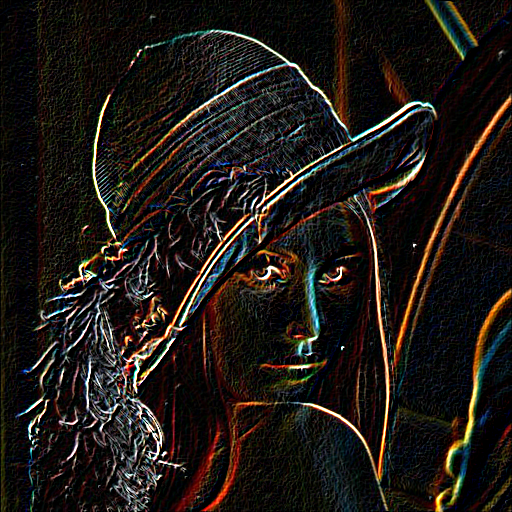

In [37]:
while True:
    if(image_process_vdma.readchannel.activeframe == 0):
        out_frame = image_process_vdma.readchannel.readframe()
        plt_image_out = Image.fromarray(out_frame)
        display(plt_image_out)
        break;
image_process_vdma.readchannel.stop()
image_process_vdma.writechannel.stop()


In [38]:
del out_frame
del image_frame

In [7]:
hist_hthr=50
hist_lthr=80
canny_ip.write(0x10,hist_hthr)
canny_ip.write(0x18, hist_lthr)
canny_ip.write(0x00,0x81) # start 必须加不然卡死

canny_vdma.readchannel.mode=VideoMode(width,height,24)
canny_vdma.readchannel.start()

canny_vdma.writechannel.mode=VideoMode(width,height,32)
canny_vdma.writechannel.start()

image_frame = canny_vdma.writechannel.newframe()

image_frame[:]=np.array(rgba_plt_image)#original_plt_image#np.array(original_image)
canny_vdma.writechannel.writeframe(image_frame)

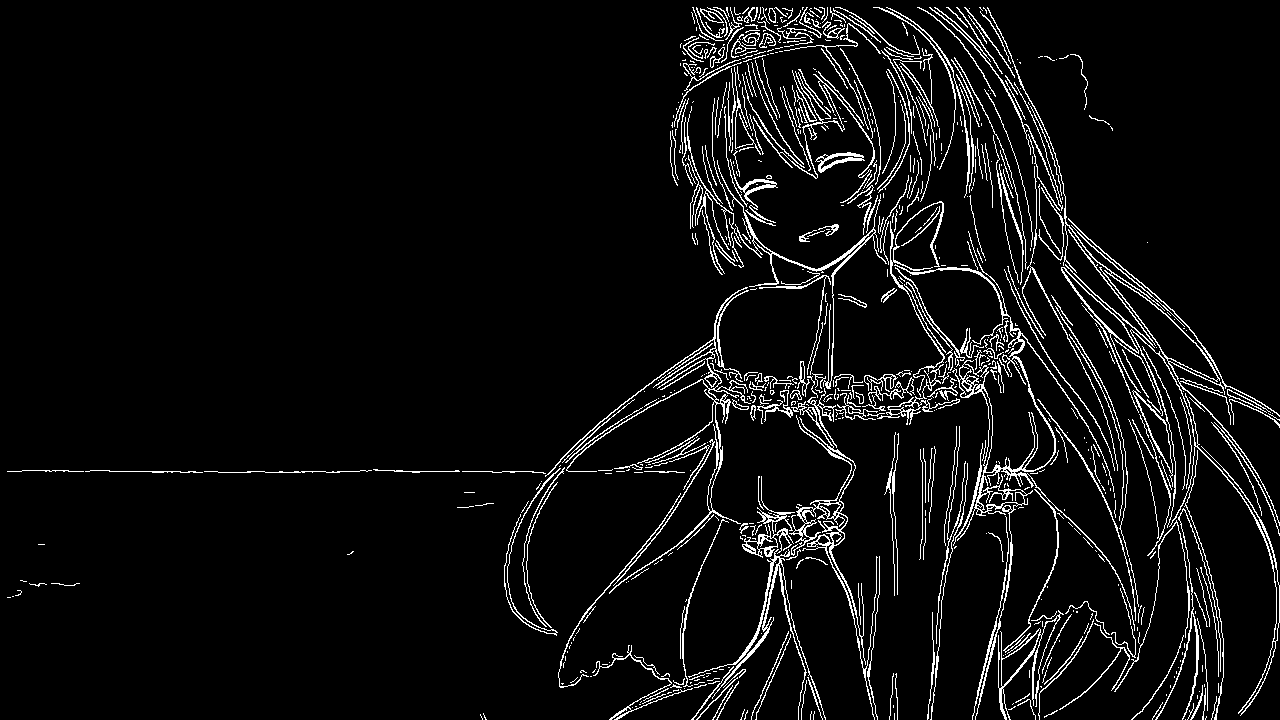

In [8]:
while True:
    if(canny_vdma.readchannel.activeframe == 0):
        out_frame = canny_vdma.readchannel.readframe()
        plt_image_out = Image.fromarray(out_frame)
        display(plt_image_out)
        break;
canny_vdma.readchannel.stop()
canny_vdma.writechannel.stop()


In [9]:
del out_frame
del image_frame


In [10]:
del height
del width


In [11]:
design.free()

In [12]:
import sys
sys.executable

'/usr/bin/python3'